In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Solution method for the rolling-only bifurcation problem

In [2]:
L = 2.5

In [3]:
def on(z):
    kon0 = 1
    eta = 2.3e4
    d = .01
    return kon0*np.exp(-eta/2*((1 - np.cos(z) + d)**2 + (np.sin(z) - z)**2))

In [4]:
def off(z):
    d = .01
    return np.exp(np.sqrt((1 - np.cos(z) + d)**2 + (np.sin(z) - z)**2))

In [12]:
def fun(z, n):
    return -(on(z) - off(z)*n)/2

In [13]:
sol = solve_ivp(fun, (np.pi, -np.pi), [0])

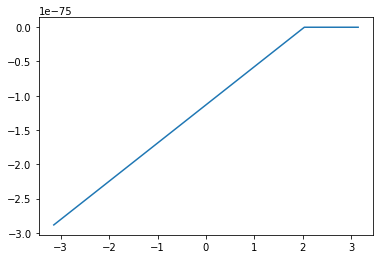

In [14]:
plt.plot(sol.t, sol.y.T)
plt.show()

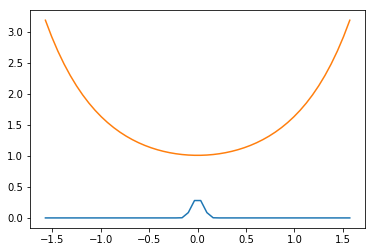

In [8]:
zspace = np.linspace(-np.pi/2, np.pi/2)
plt.plot(zspace, on(zspace), zspace, off(zspace))
plt.show()